In [6]:
%load_ext autoreload
%autoreload 2
from expressiveness_benchmark.types import Plan, Task, Language, SourceRange, Program
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from interval import interval
from itertools import combinations
sns.set(style='whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
programs = Program.load_all()
tasks = Task.load_all()

programs = programs[programs.plan != {}] # filter where plan hasn't been labeled
programs = programs[programs.task.isin(tasks.id.tolist())] # filter programs associated to a missing task
programs['category'] = programs.task.map(lambda t: tasks[tasks.id == t].category.iloc[0])

# Source metrics

<AxesSubplot:xlabel='language', ylabel='nlines'>

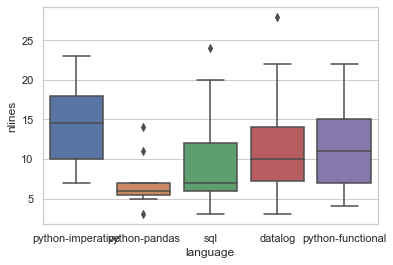

In [3]:
programs['nlines'] = programs.source.map(lambda s: len(s.split('\n')))
sns.boxplot(data=programs, x='language', y='nlines')

<AxesSubplot:xlabel='language', ylabel='nchars'>

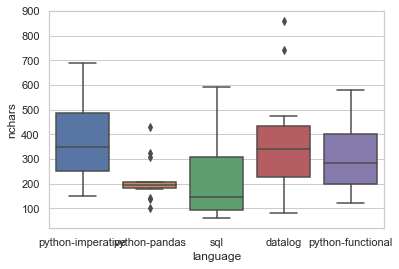

In [4]:
programs['nchars'] = programs.source.map(len)
sns.boxplot(data=programs, x='language', y='nchars')

In [65]:
group = 'category'

def bestworst(group, measure='nchars'):
    def shortest(rows):
        rows['metric'] = (rows[measure] - rows[measure].mean()) / rows[measure].std()
        return rows

    df = programs.groupby(group).apply(shortest)
    
    print('BEST PROGRAMS')
    print(df.groupby('language').apply(lambda rows: rows.iloc[rows.metric.argmin()])[group].to_string())

    print('WORST PROGRAMS')
    print(df.groupby('language').apply(lambda rows: rows.iloc[rows.metric.argmax()])[group].to_string())

In [67]:
bestworst('task')

BEST PROGRAMS
language
datalog                                    tom_hanks
python-functional                 strings_to_numbers
python-imperative                 strings_to_numbers
python-pandas        documents_with_infrequent_words
sql                               purchased_all_food
WORST PROGRAMS
language
datalog                strings_to_numbers
python-functional         customer_orders
python-imperative        youngest_over_35
python-pandas             customer_orders
sql                  unique_beer_drinkers


# Plan metrics

/Users/will/Code/expressiveness-benchmark/.env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


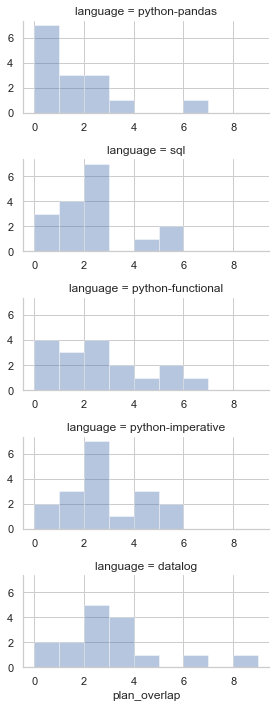

In [7]:
def coord_to_1d(lines, line, column):
    return sum([len(l) for l in lines[:line]]) + column        
    
def plan_overlap(row):
    lines = row.source.split('\n')
    plan_df = pd.DataFrame([{'key': k, **v} for k, vs in row.plan.items() for v in vs])
    plan_df['byte_start'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.start), axis=1)
    plan_df['byte_end'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.end), axis=1)

    full_intervals = plan_df.groupby('key').apply(
        lambda rows: interval[rows.byte_start.min(), rows.byte_end.max()])
    all_pairs = combinations(full_intervals.tolist(), r=2)
    return sum([1 if l & r else 0 for (l, r) in all_pairs])

programs['plan_overlap'] = programs.apply(plan_overlap, axis=1)
order = programs.groupby('language').plan_overlap.mean().sort_values().index.values
g = sns.FacetGrid(data=programs, row='language', aspect=2, height=2, row_order=order)
g.map(sns.distplot, 'plan_overlap', kde=False, bins=np.arange(0, programs.plan_overlap.max()+1))
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.tight_layout()